===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1025
Rows that have all features = NaN: 20
TRAIN rows: 899
VAL   rows: 106
TEST  rows: 20
===== START TRAINING OR LOADING MODELS =====

=== Training/Loading LSTM model ===
[LSTM] Loaded existing model from ./best_LSTM_McDonal_V1.pt
LSTM => Completed test predictions

=== Training/Loading GRU model ===
[GRU] Loaded existing model from ./best_GRU_McDonal_V1.pt
GRU => Completed test predictions

=== Training/Loading RNN model ===
[RNN] Loaded existing model from ./best_RNN_McDonal_V1.pt
RNN => Completed test predictions

=== Training/Loading CNN model ===
[CNN] Loaded existing model from ./best_CNN_McDonal_V1.pt
CNN => Completed test predictions

=== Training/Loading Transformer model ===
[Transformer] Loaded existing model from ./best_Transformer_McDonal_V1.pt


/home/yuzhe/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer => Completed test predictions

=== Training/Loading N-BEATS model ===
[N-BEATS] Loaded existing model from ./best_N-BEATS_McDonal_V1.pt
N-BEATS => Completed test predictions

=== Training/Loading N-HITS model ===
[N-HITS] Loaded existing model from ./best_N-HITS_McDonal_V1.pt
N-HITS => Completed test predictions

=== Training/Loading SVM model ===
[SVM] Loaded existing model from ./best_SVM_McDonal_V1.pkl
SVM => Completed test predictions

=== Training/Loading Boost model ===
[Boost] Loaded existing model from ./best_Boost_McDonal_V1.pkl
Boost => Completed test predictions


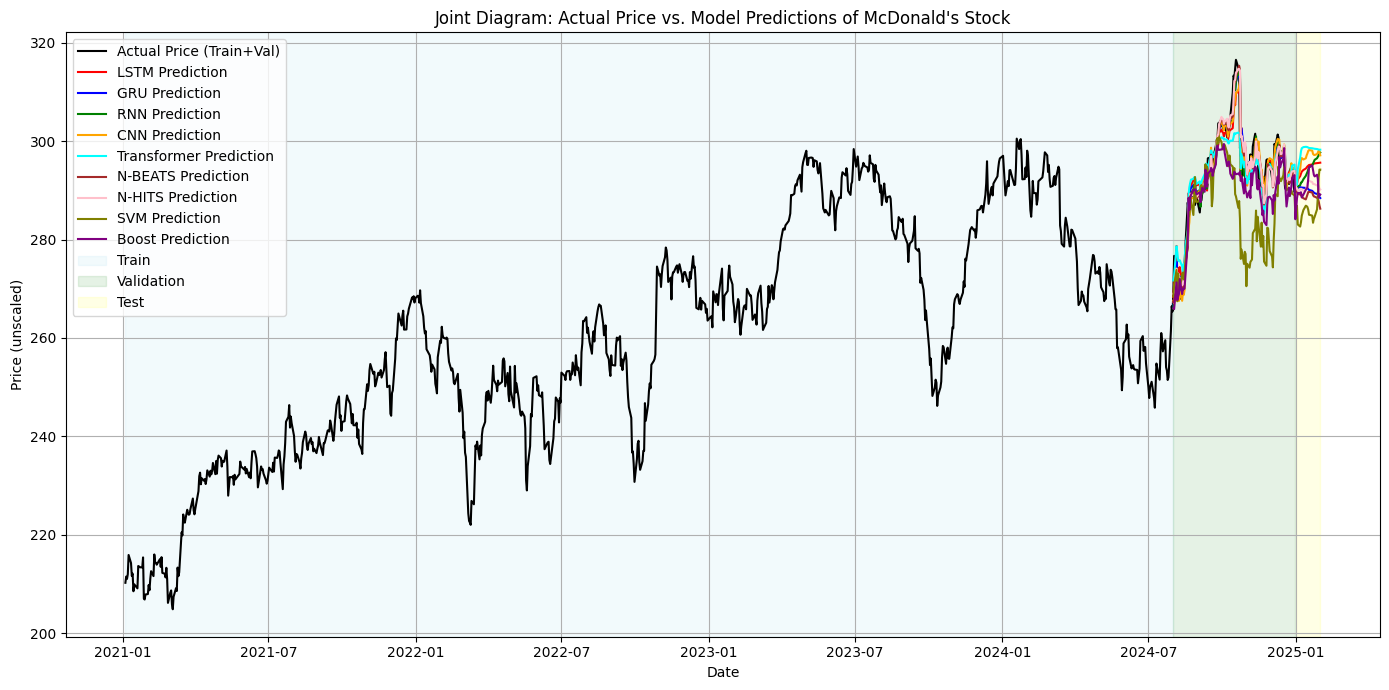

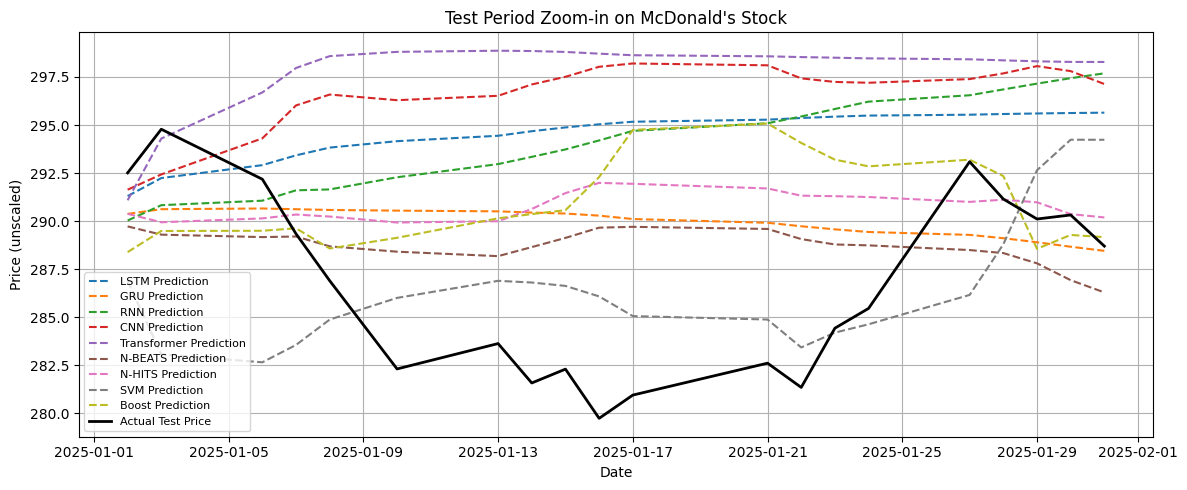

/tmp/ipykernel_632264/42319269.py:685: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(pt_path, map_location=device))
/home/yuzhe/.local/l

===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====
   ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
0    2025-01-01           288.389008          290.242615          291.973877   
1    2025-01-02           289.487549          289.181732          291.779816   
2    2025-01-03           289.497955          289.492096          291.487854   
3    2025-01-04           289.626770          288.591187          290.668213   
4    2025-01-05           288.573639          287.954132          289.095428   
5    2025-01-06           289.131653          288.241913          290.335571   
6    2025-01-07           290.146423          289.335022          290.602448   
7    2025-01-08           290.365387          290.856628          292.125702   
8    2025-01-09           290.570435          290.825867          291.598541   
9    2025-01-10           292.293671          290.800354          292.325470   
10   2025-01-11           294.745056          292.5444

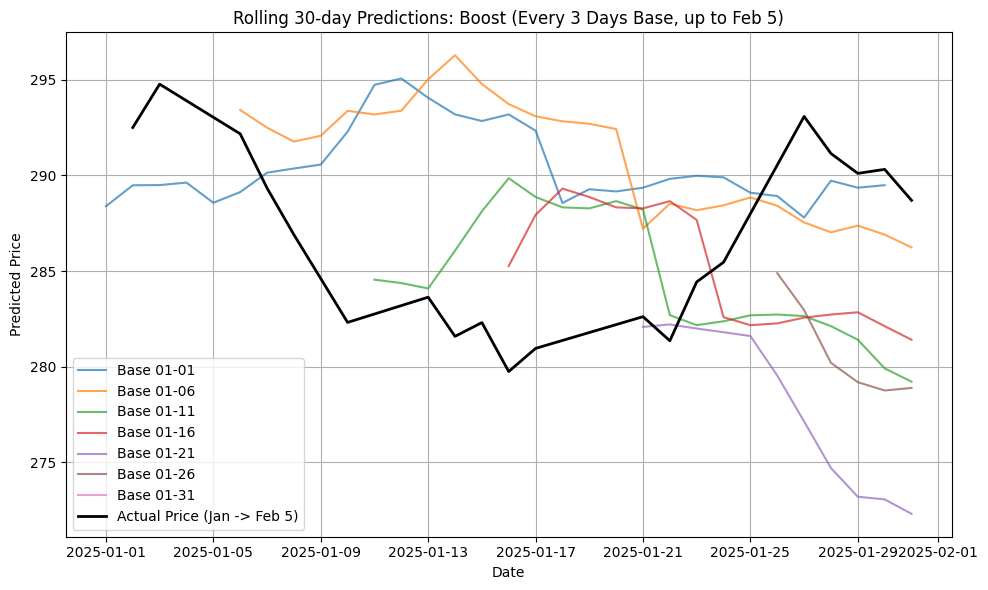

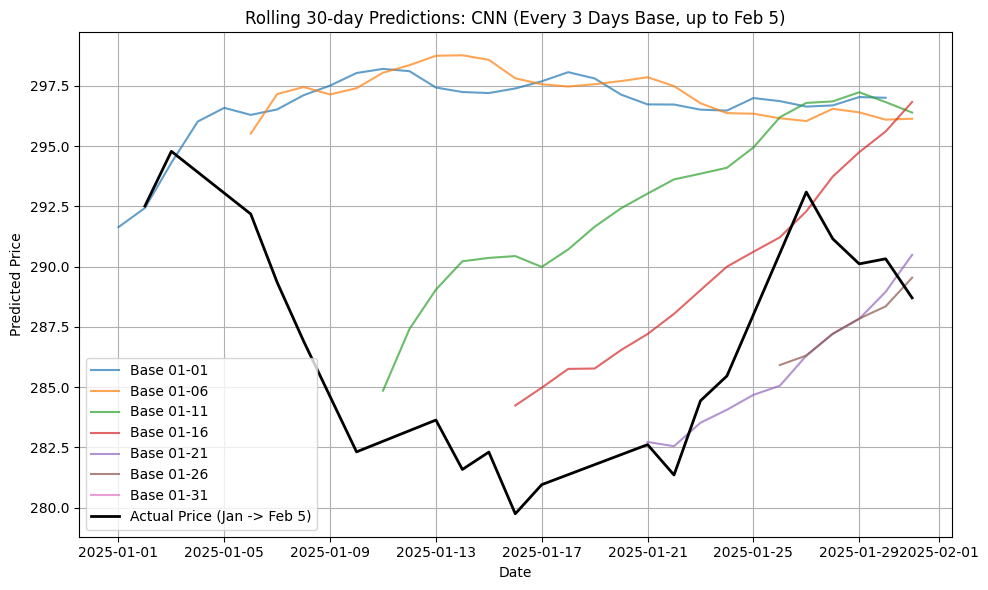

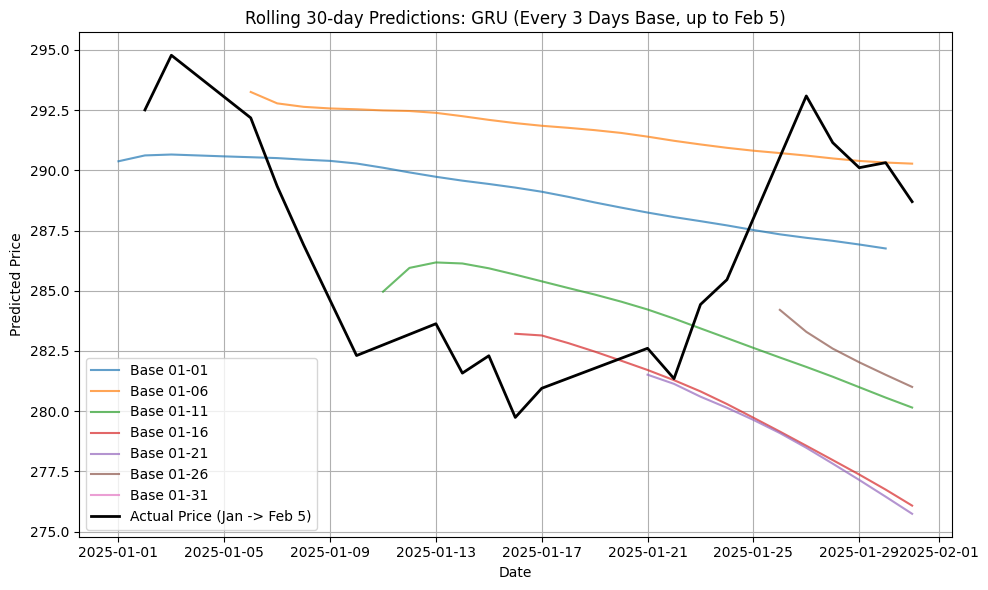

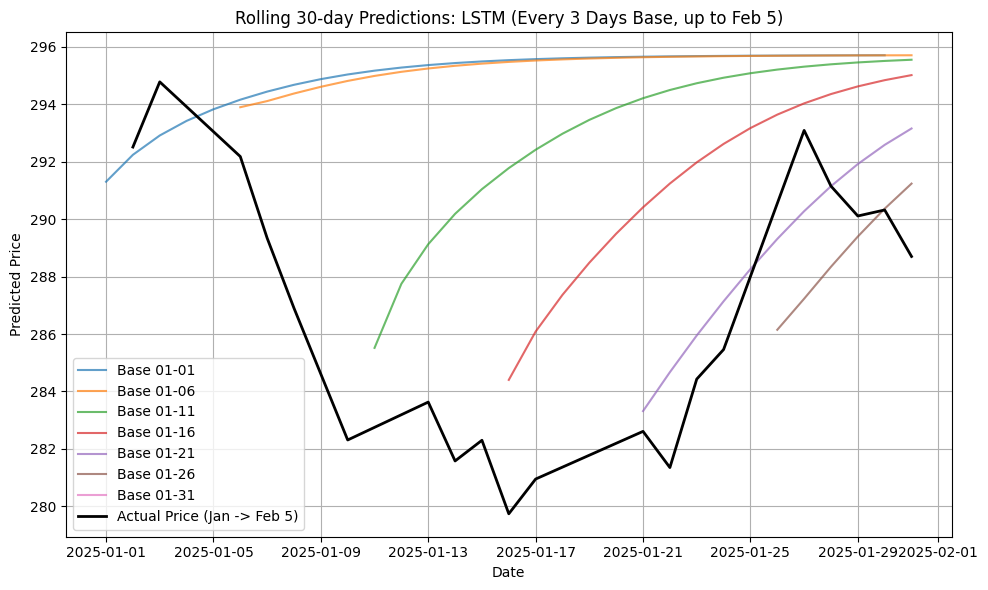

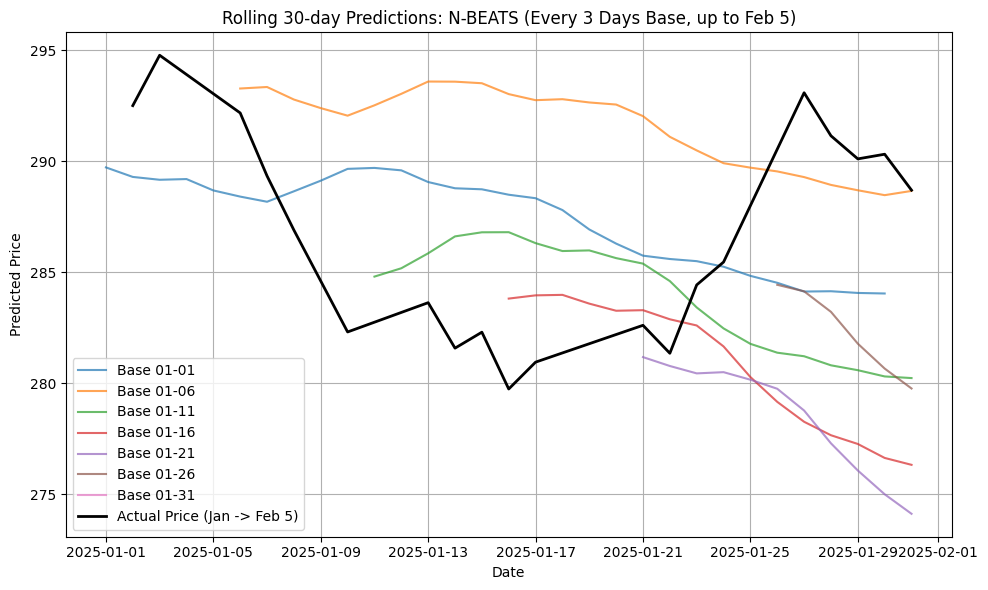

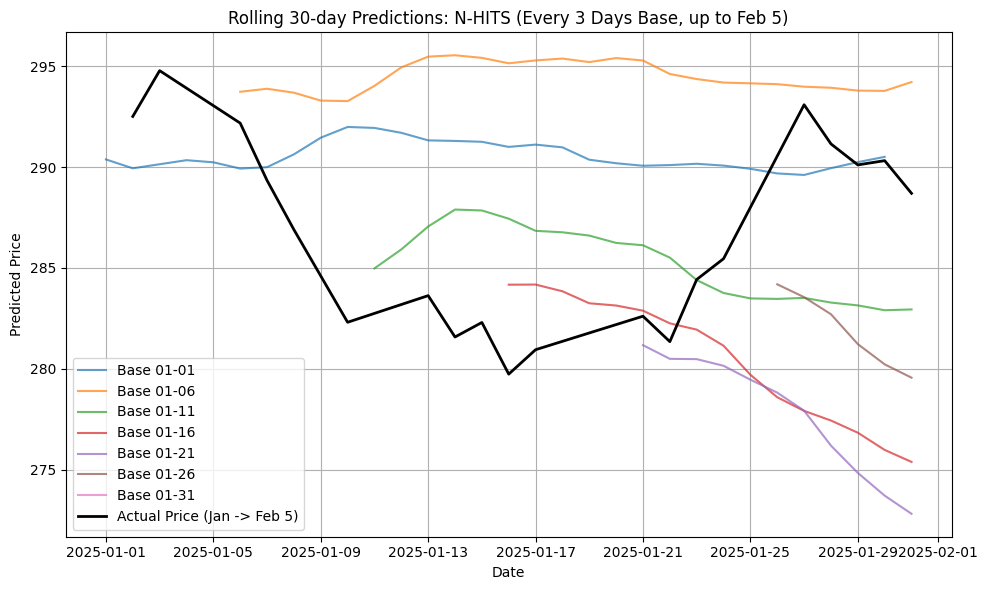

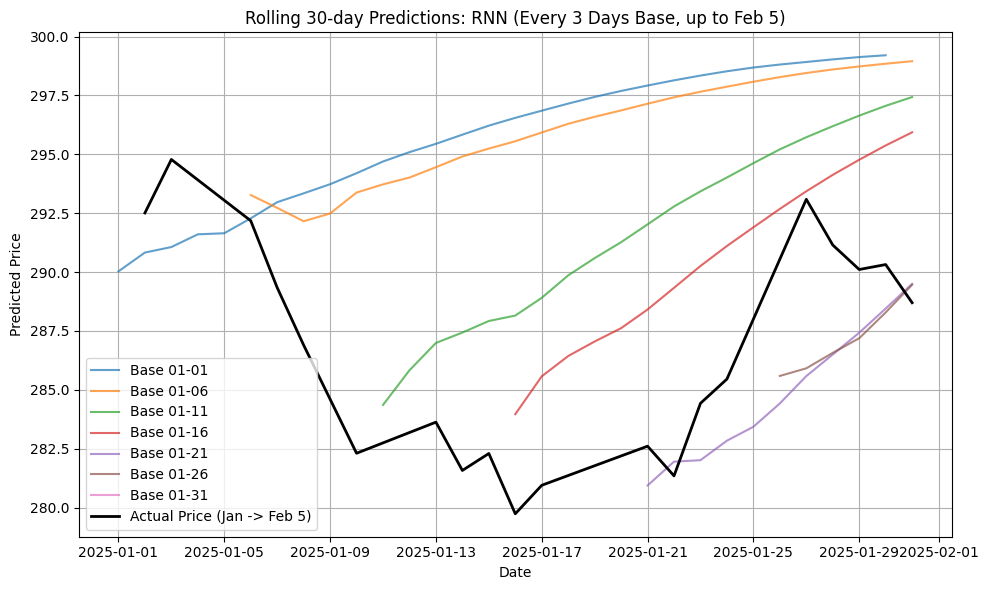

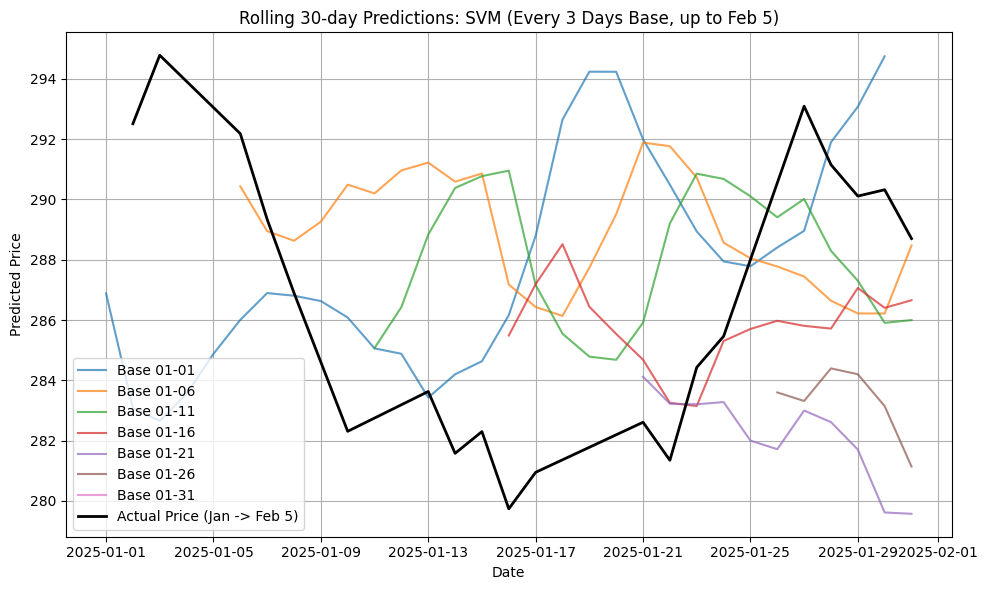

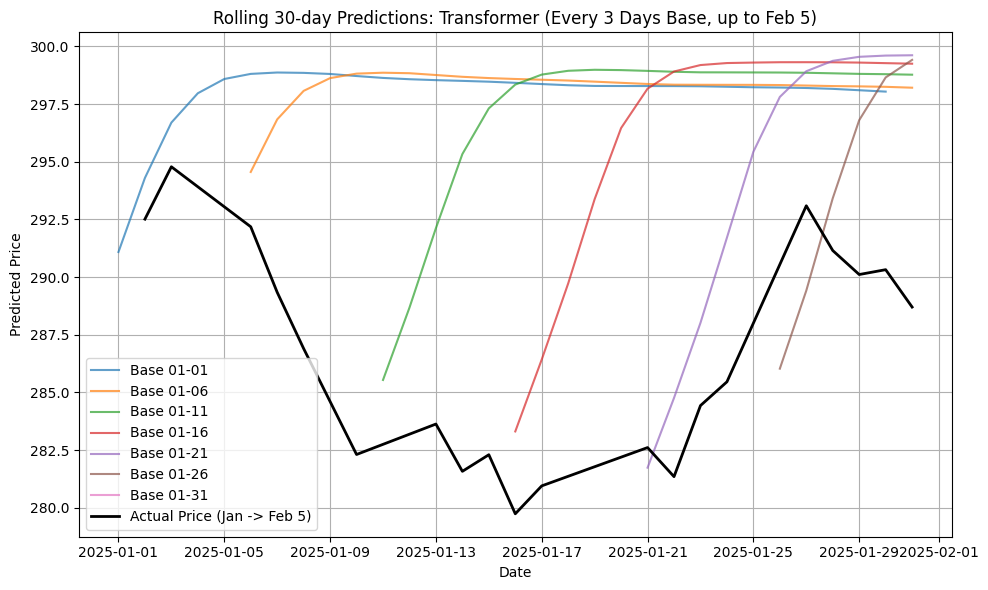

All done.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ============================================
# 1. Set random seeds
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ============================================
# Global hyperparameters
# ============================================
WINDOW_SIZE = 35
NUM_EPOCHS  = 800
features = ["Price", "Open", "High", "Low"]

# Filenames (adjust as needed)
csv_file_train = "McDonald’s Stock Price History.csv"             # Partial / older data
csv_file_complete = "McDonald’s Stock Price History_Complete.csv"  # Full data (incl. future)
best_models_dir = "."  # Directory for saved models (change if needed)

# ============================================
# 2. Load & Clean CSV (Training CSV)
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# Train/Val/Test cutoff dates
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-01")  # We'll do day-by-day from Jan 1 to Jan 31

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ============================================
# 3. Fit MinMaxScaler on TRAIN only
# ============================================
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# Optionally, save the scaler if needed
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create the training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Flatten for sklearn
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))

# ============================================
# 5. Validation Utilities
# ============================================
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            if d > val_end:
                break
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # Reveal actual for day d
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 6. Define the base PyTorch model
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

# ============================================
# Early Stopping
# ============================================
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ============================================
# 7. Inverse transform helper
# ============================================
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ============================================
# 8. Training function for PyTorch
# ============================================
def train_model(model_type="LSTM", num_epochs=800):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pt")
    
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ============================================
# 8B. Training function for sklearn
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pkl")
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ============================================
# 9. Walk-forward test (Original style)
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 10. Evaluate & Plot
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # Plot 1: Joint diagram
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Test Period Zoom-in
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         linestyle="--", label=f"{model_name} Prediction")
        # Load actual test prices from the complete CSV
        df_complete_test = pd.read_csv(csv_file_complete)
        df_complete_test["Date"] = pd.to_datetime(df_complete_test["Date"])
        df_complete_test.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete_test.sort_values("Date", inplace=True)
        df_test_actual = df_complete_test[df_complete_test["Date"] >= test_cutoff].copy()
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')

        plt.title("Test Period Zoom-in on McDonald's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ============================================
# 11. MAIN
# ============================================
if __name__ == "__main__":
    # 1) Train/Load all models
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}

    print("===== START TRAINING OR LOADING MODELS =====")
    for mt in all_model_types:
        print(f"\n=== Training/Loading {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)

        # Validation predictions
        if mt in ["SVM", "Transformer", "Boost"]:
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )

        # Test predictions (original approach)
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} => Completed test predictions")

    # 2) Evaluate & Plot original approach
    evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff)

    # ============================================
    # 3) New Rolling 30-Day Forecast from 2025-01-01 to 2025-01-31
    # ============================================
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"] = pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    for col in features:
        df_complete_all[col] = (
            df_complete_all[col].astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)

    # Re-build dictionary of trained models:
    models_dict = {}
    for mt in all_model_types:
        if mt in ["SVM", "Boost", "GPR"]:
            pkl_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pkl")
            if not os.path.exists(pkl_path):
                print(f"Warning: {pkl_path} not found. Skipping.")
                continue
            loaded_model = joblib.load(pkl_path)
            models_dict[mt] = SklearnWrapper(loaded_model)
        else:
            pt_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pt")
            if not os.path.exists(pt_path):
                print(f"Warning: {pt_path} not found. Skipping.")
                continue
            new_model = BaseModel(model_type=mt, window_width=WINDOW_SIZE).to(device)
            new_model.load_state_dict(torch.load(pt_path, map_location=device))
            new_model.eval()
            models_dict[mt] = new_model

    def get_latest_window(actual_df, current_date, window=WINDOW_SIZE):
        mask = actual_df["Date"] < current_date
        df_subset = actual_df.loc[mask].copy()
        df_subset.sort_values("Date", inplace=True)
        if len(df_subset) < window:
            return None
        df_window = df_subset.iloc[-window:].copy()
        df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
        arr_window = scaler.transform(df_window[features])
        return arr_window

    def forecast_30_days_from_date(model, df_actual, start_date, window=WINDOW_SIZE, horizon=30, device=device):
        arr_window = get_latest_window(df_actual, start_date, window=window)
        if arr_window is None:
            return pd.DataFrame()

        forecast_records = []
        rolling_buffer = np.copy(arr_window)
        current_date = pd.to_datetime(start_date)
        for i in range(horizon):
            X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_4_scaled = model(X_input).cpu().numpy()[0]
            pred_4_unscaled = scaler.inverse_transform(pred_4_scaled.reshape(1, -1))[0]
            forecast_day = current_date + pd.Timedelta(days=i)
            forecast_records.append({
                "ForecastDate": forecast_day,
                "Pred_Price_unscaled": pred_4_unscaled[0],
                "Pred_Open_unscaled":  pred_4_unscaled[1],
                "Pred_High_unscaled":  pred_4_unscaled[2],
                "Pred_Low_unscaled":   pred_4_unscaled[3],
            })
            # Shift by 1
            new_row_scaled = pred_4_scaled.reshape(1, -1)
            rolling_buffer = np.vstack((rolling_buffer[1:], new_row_scaled))
        return pd.DataFrame(forecast_records)

    def rolling_moe_forecasts(models_dict, df_actual, start_day="2025-01-01", end_day="2025-01-31",
                              window_size=WINDOW_SIZE, horizon=30, device=device):
        df_actual["Date"] = pd.to_datetime(df_actual["Date"])
        start_day = pd.to_datetime(start_day)
        end_day   = pd.to_datetime(end_day)
        all_days = pd.date_range(start=start_day, end=end_day, freq="D")
        results_list = []

        for base_date in all_days:
            for model_name, model_obj in models_dict.items():
                df_fcst = forecast_30_days_from_date(
                    model=model_obj,
                    df_actual=df_actual,
                    start_date=base_date,
                    window=window_size,
                    horizon=horizon,
                    device=device
                )
                if df_fcst.empty:
                    continue
                df_fcst["BaseDate"] = base_date
                df_fcst["Model"] = model_name
                results_list.append(df_fcst)

        df_all_forecasts = pd.concat(results_list, ignore_index=True)
        df_all_forecasts.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
        df_all_forecasts.reset_index(drop=True, inplace=True)
        return df_all_forecasts

    final_rolling_fcst = rolling_moe_forecasts(
        models_dict=models_dict,
        df_actual=df_complete_all,
        start_day="2025-01-01",
        end_day="2025-01-31",
        window_size=WINDOW_SIZE,
        horizon=30,
        device=device
    )
    print("===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====")
    print(final_rolling_fcst.head(50))
    print("Total rows in final_rolling_fcst:", len(final_rolling_fcst))

    # ============================================
    # 4) Additional Plots: truncated at 2025-02-05, only show every 3rd base date
    # ============================================
    # We'll overlay the actual daily prices from 2025-01-01 to 2025-02-05
    # (If your CSV extends beyond that, it's okay.)
    df_actual_jan = df_complete_all.copy()
    mask_jan = (df_actual_jan["Date"] >= "2025-01-01") & (df_actual_jan["Date"] <= "2025-02-05")
    df_actual_jan = df_actual_jan.loc[mask_jan].copy()

    cutoff_date_plot = pd.to_datetime("2025-01-31")

    unique_models = final_rolling_fcst["Model"].unique()
    for m in unique_models:
        df_model_fcst = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()

        plt.figure(figsize=(10,6))
        base_dates_all = sorted(df_model_fcst["BaseDate"].unique())
        # Only plot forecasts for every 3rd base date
        base_dates_subset = base_dates_all[::5]
        
        for bd in base_dates_subset:
            df_bd = df_model_fcst[df_model_fcst["BaseDate"] == bd].copy()
            # Truncate each forecast at 2025-02-05
            df_bd = df_bd[df_bd["ForecastDate"] <= cutoff_date_plot]
            short_label = bd.strftime('%m-%d')  # e.g. "01-01", "01-04", etc.
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.7, label=f"Base {short_label}")
        
        # Plot actual daily price up to 2025-02-05
        plt.plot(df_actual_jan["Date"], df_actual_jan["Price"],
                 color="black", linewidth=2, label="Actual Price (Jan -> Feb 5)")

        plt.title(f"Rolling 30-day Predictions: {m} (Every 3 Days Base, up to Feb 5)")
        plt.xlabel("Date")
        plt.ylabel("Predicted Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("All done.")


===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1025
Rows that have all features = NaN: 20
TRAIN rows: 899
VAL   rows: 106
TEST  rows: 20
===== START TRAINING OR LOADING MODELS =====

=== Training/Loading LSTM model ===
[LSTM] Loaded existing model from ./best_LSTM_McDonal_V1.pt
LSTM => Completed test predictions

=== Training/Loading GRU model ===
[GRU] Loaded existing model from ./best_GRU_McDonal_V1.pt
GRU => Completed test predictions

=== Training/Loading RNN model ===
[RNN] Loaded existing model from ./best_RNN_McDonal_V1.pt
RNN => Completed test predictions

=== Training/Loading CNN model ===
[CNN] Loaded existing model from ./best_CNN_McDonal_V1.pt
CNN => Completed test predictions

=== Training/Loading Transformer model ===
[Transformer] Loaded existing model from ./best_Transformer_McDonal_V1.pt


/home/yuzhe/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer => Completed test predictions

=== Training/Loading N-BEATS model ===
[N-BEATS] Loaded existing model from ./best_N-BEATS_McDonal_V1.pt
N-BEATS => Completed test predictions

=== Training/Loading N-HITS model ===
[N-HITS] Loaded existing model from ./best_N-HITS_McDonal_V1.pt
N-HITS => Completed test predictions

=== Training/Loading SVM model ===
[SVM] Loaded existing model from ./best_SVM_McDonal_V1.pkl
SVM => Completed test predictions

=== Training/Loading Boost model ===
[Boost] Loaded existing model from ./best_Boost_McDonal_V1.pkl
Boost => Completed test predictions


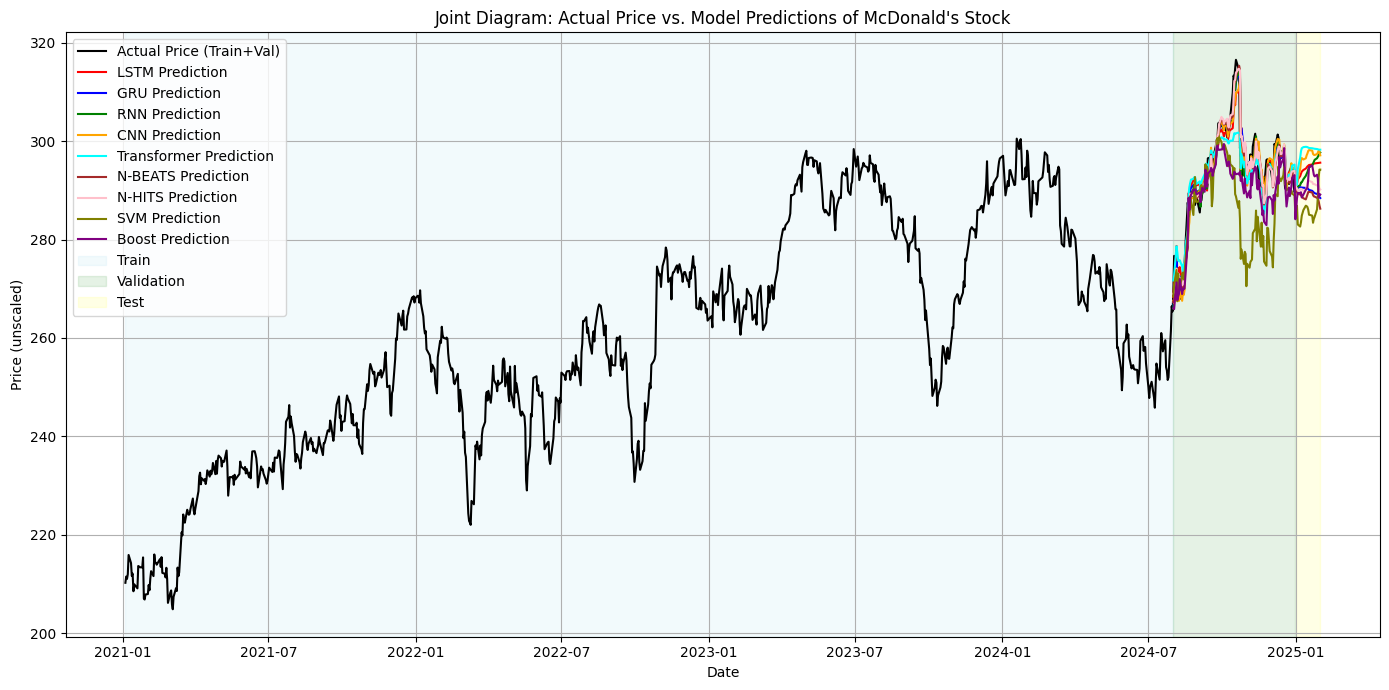

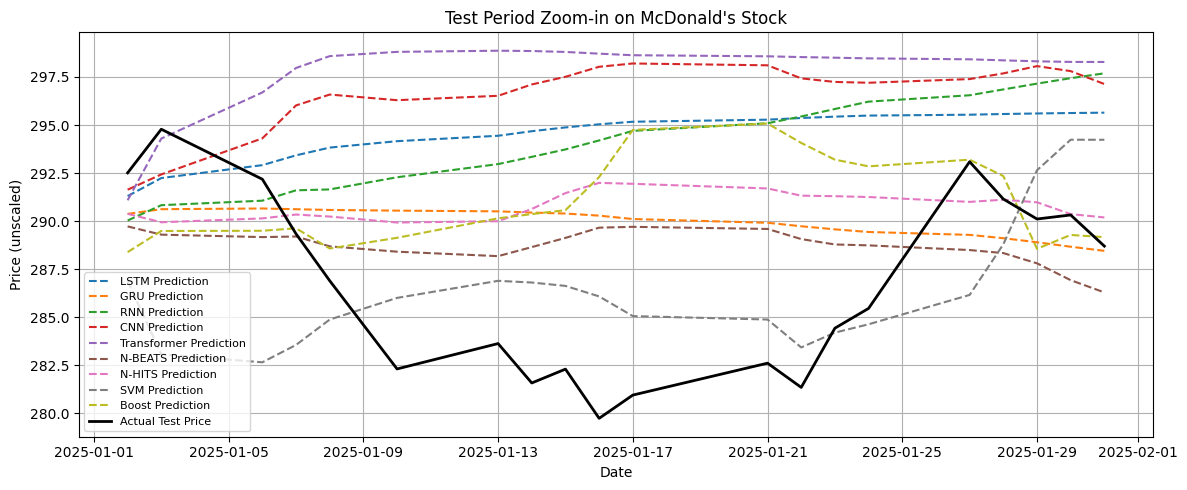

/tmp/ipykernel_632264/1593280155.py:688: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(pt_path, map_location=device))
/home/yuzhe/.local

===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====
   ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
0    2025-01-01           288.389008          290.242615          291.973877   
1    2025-01-02           289.487549          289.181732          291.779816   
2    2025-01-03           289.497955          289.492096          291.487854   
3    2025-01-04           289.626770          288.591187          290.668213   
4    2025-01-05           288.573639          287.954132          289.095428   
5    2025-01-06           289.131653          288.241913          290.335571   
6    2025-01-07           290.146423          289.335022          290.602448   
7    2025-01-08           290.365387          290.856628          292.125702   
8    2025-01-09           290.570435          290.825867          291.598541   
9    2025-01-10           292.293671          290.800354          292.325470   
10   2025-01-11           294.745056          292.5444

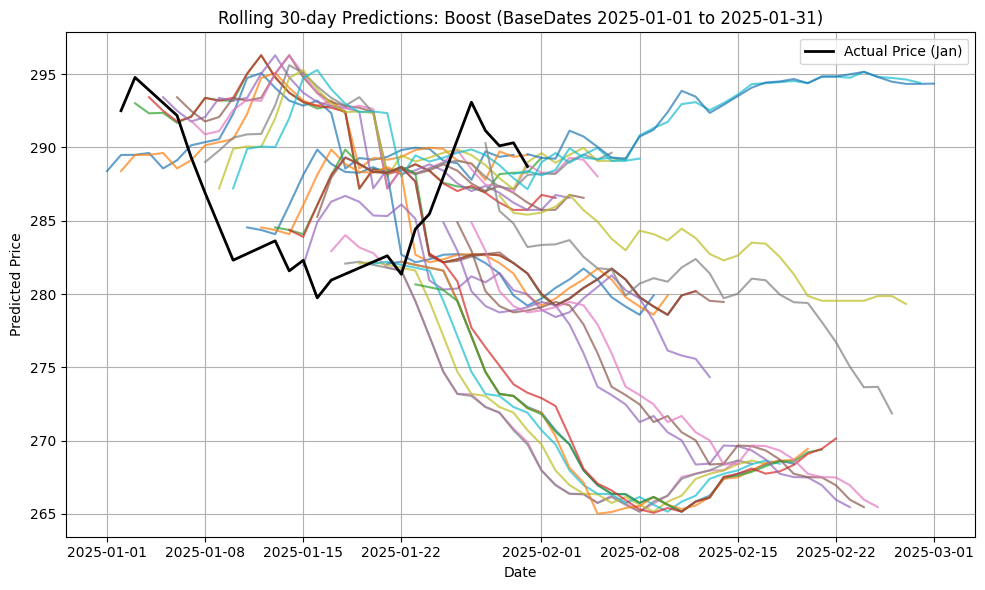

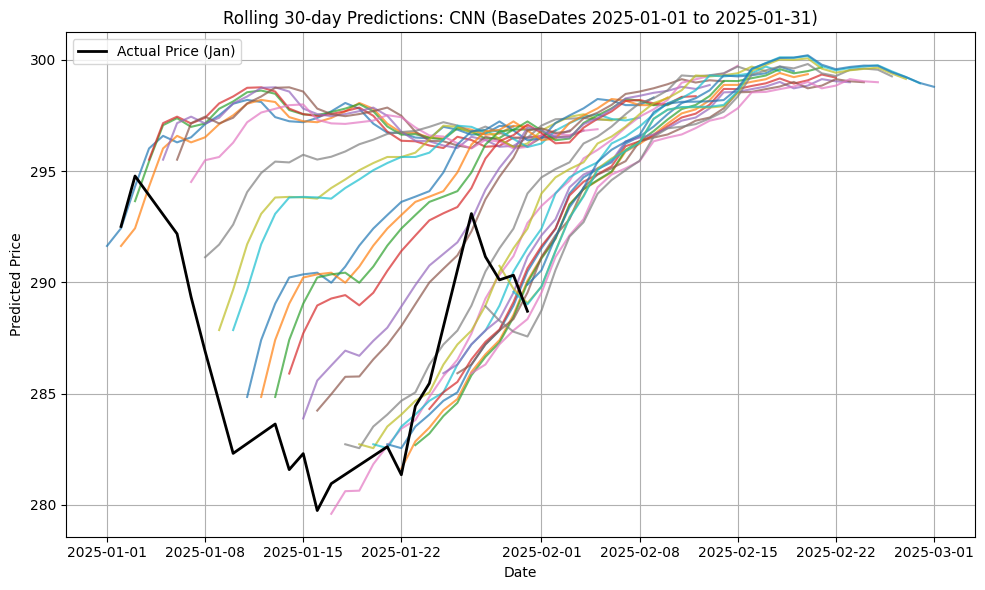

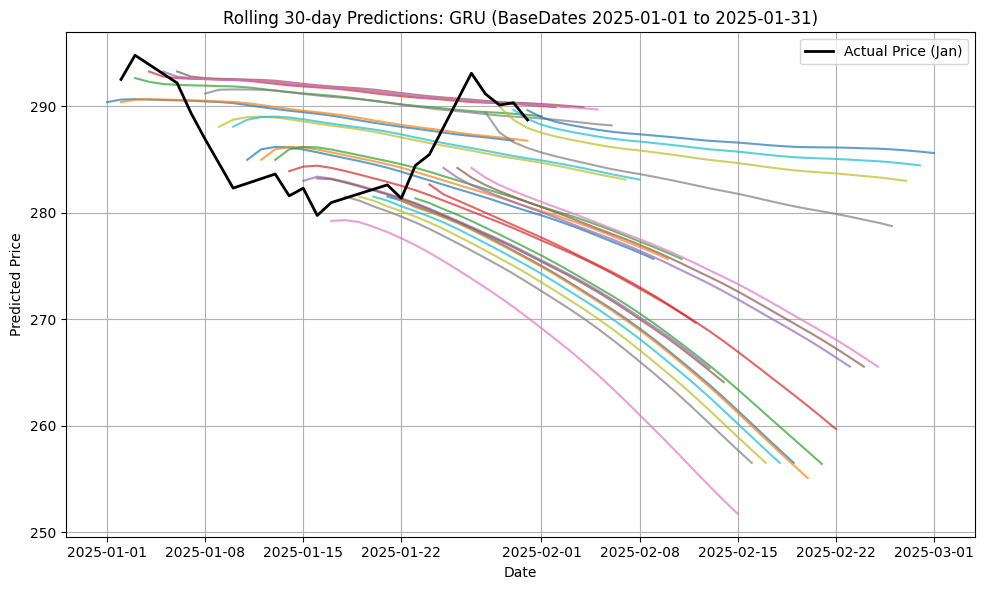

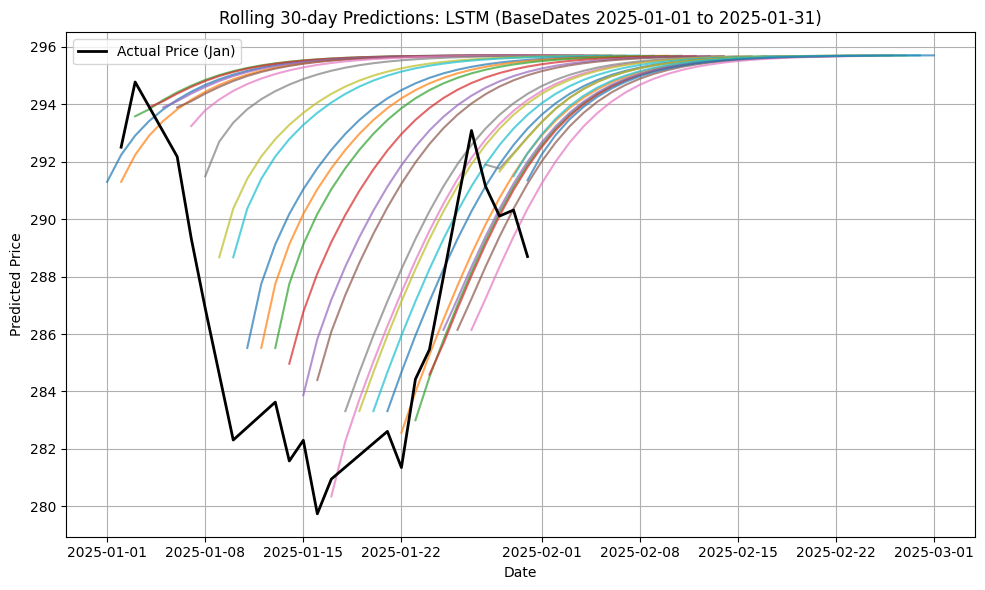

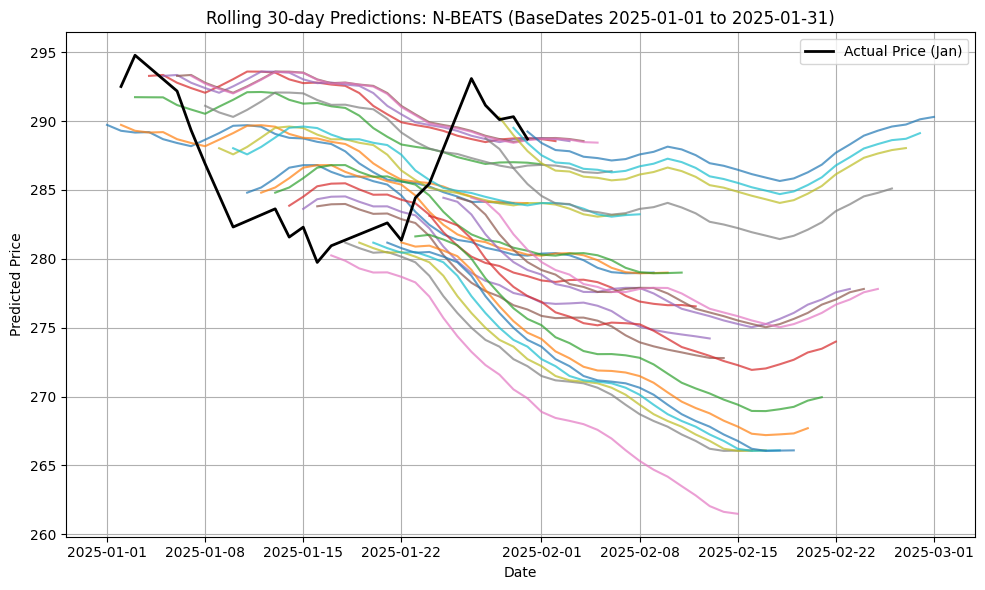

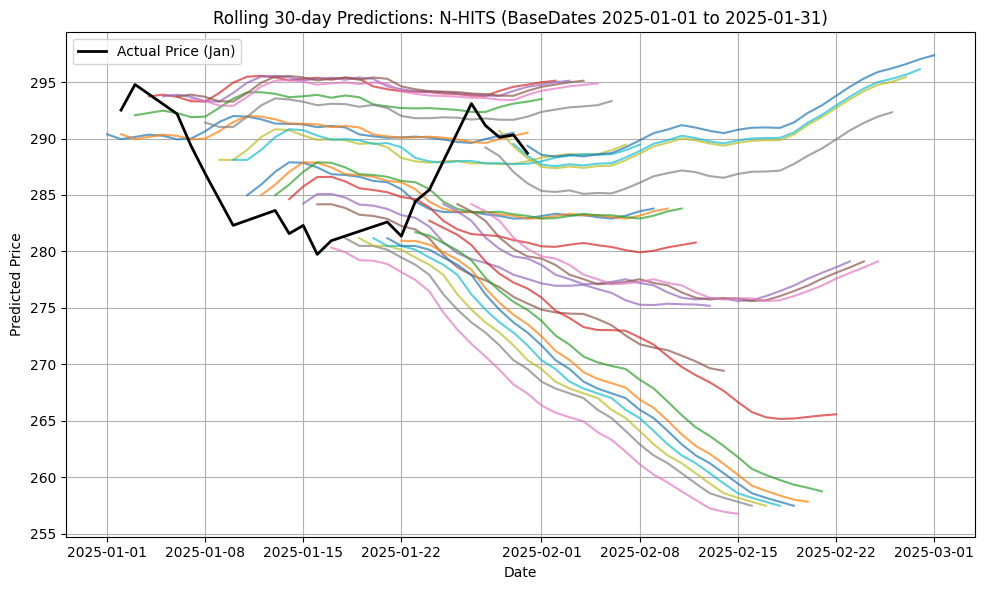

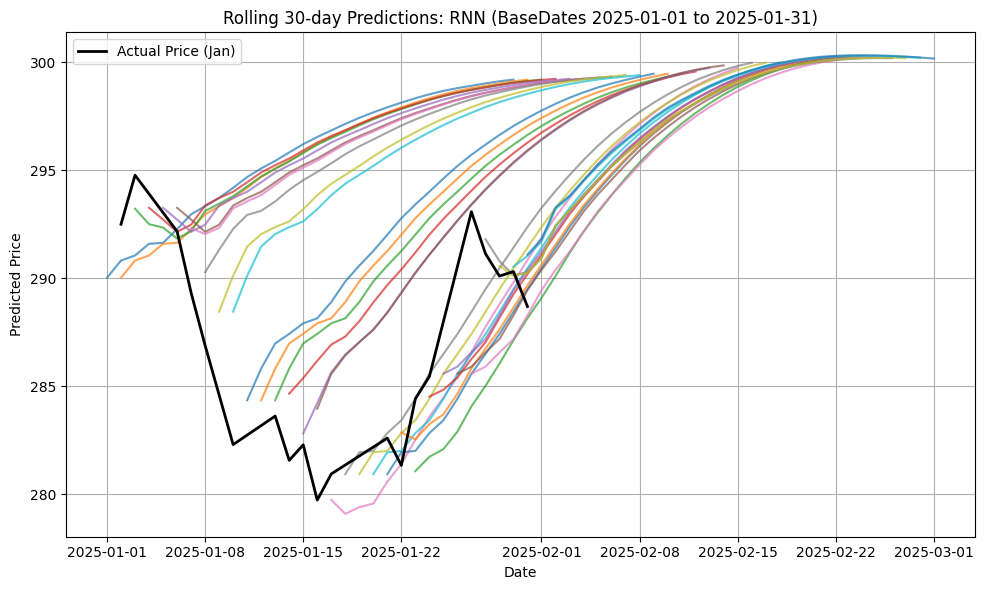

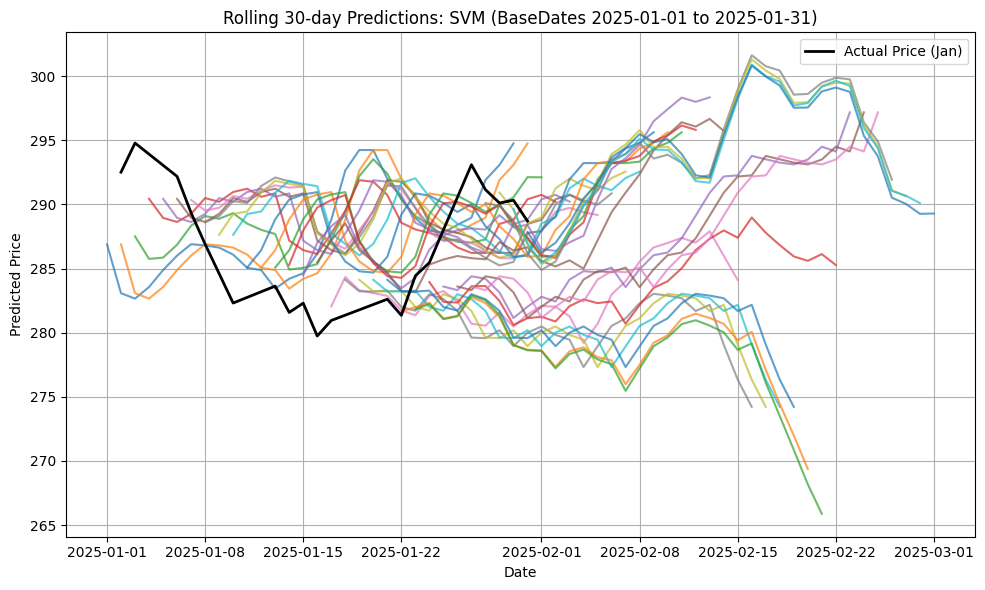

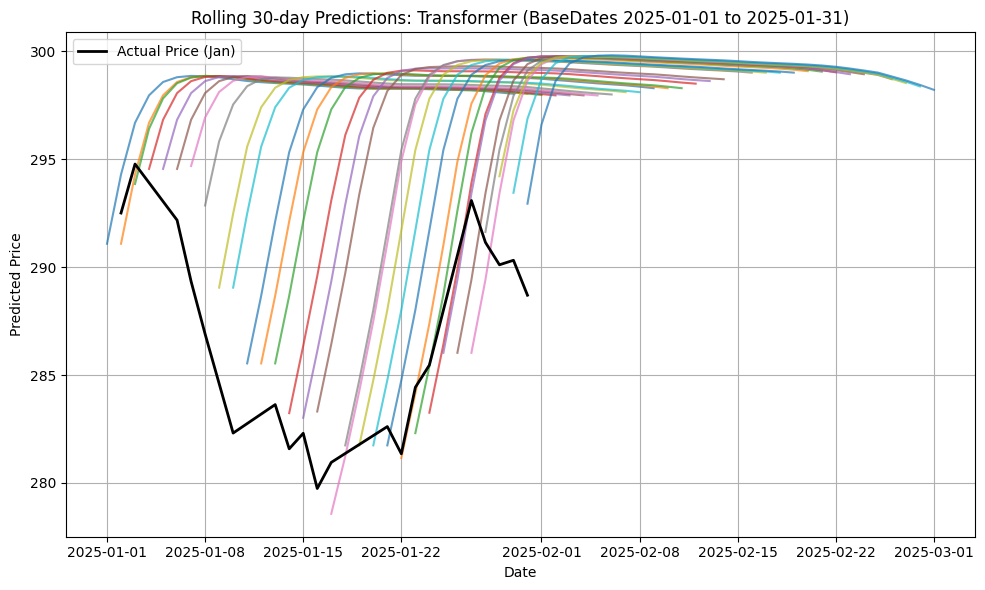

All done.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ============================================
# 1. Set random seeds
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ============================================
# Global hyperparameters
# ============================================
WINDOW_SIZE = 35
NUM_EPOCHS  = 800
features = ["Price", "Open", "High", "Low"]

# Filenames (adjust as needed)
csv_file_train = "McDonald’s Stock Price History.csv"             # Partial / older data
csv_file_complete = "McDonald’s Stock Price History_Complete.csv"  # Full data (incl. future)
best_models_dir = "."  # Directory for saved models (change if needed)

# ============================================
# 2. Load & Clean CSV (Training CSV)
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# Train/Val/Test cutoff dates (adjust if needed)
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-01")  # We will do day-by-day from Jan 1 to Jan 31

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ============================================
# 3. Fit MinMaxScaler on TRAIN only
# ============================================
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# Optionally, save the scaler if needed
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create the training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Flatten for sklearn
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all shape: (n_samples, 4)

# ============================================
# 5. Validation Utilities
# ============================================
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    # Initialize
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            if d > val_end:
                break
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # Reveal actual for day d
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 6. Define the base PyTorch model
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)  
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

# ============================================
# Early Stopping
# ============================================
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ============================================
# 7. Inverse transform helper
# ============================================
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ============================================
# 8. Training function for PyTorch
# ============================================
def train_model(model_type="LSTM", num_epochs=800):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pt")
    
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ============================================
# 8B. Training function for sklearn
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pkl")
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ============================================
# 9. Walk-forward test (Original style)
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 10. Evaluate & Plot
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # Plot 1: Joint diagram
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Test Period Zoom-in
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         linestyle="--", label=f"{model_name} Prediction")
        # Load actual test prices from the complete CSV for final overlay
        df_complete_test = pd.read_csv(csv_file_complete)
        df_complete_test["Date"] = pd.to_datetime(df_complete_test["Date"])
        df_complete_test.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete_test.sort_values("Date", inplace=True)
        df_test_actual = df_complete_test[df_complete_test["Date"] >= test_cutoff].copy()
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')

        plt.title("Test Period Zoom-in on McDonald's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ============================================
# 11. MAIN
# ============================================
if __name__ == "__main__":
    # 1) Train/Load all models
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}

    print("===== START TRAINING OR LOADING MODELS =====")
    for mt in all_model_types:
        print(f"\n=== Training/Loading {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)

        # Validation predictions
        if mt in ["SVM", "Transformer", "Boost"]:
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )

        # Test predictions (original approach)
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} => Completed test predictions")

    # 2) Evaluate & Plot original approach
    evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff)

    # ============================================
    # 3) New Rolling 30-Day Forecast from 2025-01-01 to 2025-01-31
    # ============================================
    # Load the complete CSV
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"] = pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    for col in features:
        df_complete_all[col] = (
            df_complete_all[col].astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)

    # Re-build the dictionary of loaded/trained models:
    models_dict = {}
    for mt in all_model_types:
        if mt in ["SVM", "Boost", "GPR"]:
            pkl_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pkl")
            if not os.path.exists(pkl_path):
                print(f"Warning: {pkl_path} not found. Skipping.")
                continue
            loaded_model = joblib.load(pkl_path)
            models_dict[mt] = SklearnWrapper(loaded_model)
        else:
            pt_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pt")
            if not os.path.exists(pt_path):
                print(f"Warning: {pt_path} not found. Skipping.")
                continue
            new_model = BaseModel(model_type=mt, window_width=WINDOW_SIZE).to(device)
            new_model.load_state_dict(torch.load(pt_path, map_location=device))
            new_model.eval()
            models_dict[mt] = new_model

    # Helper: get the last 'window' days of actual data
    def get_latest_window(actual_df, current_date, window=WINDOW_SIZE):
        mask = actual_df["Date"] < current_date
        df_subset = actual_df.loc[mask].copy()
        df_subset.sort_values("Date", inplace=True)
        if len(df_subset) < window:
            return None
        df_window = df_subset.iloc[-window:].copy()
        df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
        arr_window = scaler.transform(df_window[features])
        return arr_window

    # Forecast 30 days from a single day vantage (no cheating)
    def forecast_30_days_from_date(model, df_actual, start_date, window=WINDOW_SIZE, horizon=30, device=device):
        arr_window = get_latest_window(df_actual, start_date, window=window)
        if arr_window is None:
            return pd.DataFrame()

        forecast_records = []
        rolling_buffer = np.copy(arr_window)
        current_date = pd.to_datetime(start_date)
        for i in range(horizon):
            X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_4_scaled = model(X_input).cpu().numpy()[0]
            pred_4_unscaled = scaler.inverse_transform(pred_4_scaled.reshape(1, -1))[0]
            forecast_day = current_date + pd.Timedelta(days=i)
            forecast_records.append({
                "ForecastDate": forecast_day,
                "Pred_Price_unscaled": pred_4_unscaled[0],
                "Pred_Open_unscaled":  pred_4_unscaled[1],
                "Pred_High_unscaled":  pred_4_unscaled[2],
                "Pred_Low_unscaled":   pred_4_unscaled[3],
            })
            # Shift by 1
            new_row_scaled = pred_4_scaled.reshape(1, -1)
            rolling_buffer = np.vstack((rolling_buffer[1:], new_row_scaled))
        return pd.DataFrame(forecast_records)

    # Rolling from Jan 1 to Jan 31
    def rolling_moe_forecasts(models_dict, df_actual, start_day="2025-01-01", end_day="2025-01-31",
                              window_size=WINDOW_SIZE, horizon=30, device=device):
        df_actual["Date"] = pd.to_datetime(df_actual["Date"])
        start_day = pd.to_datetime(start_day)
        end_day   = pd.to_datetime(end_day)
        all_days = pd.date_range(start=start_day, end=end_day, freq="D")
        results_list = []

        for base_date in all_days:
            for model_name, model_obj in models_dict.items():
                df_fcst = forecast_30_days_from_date(
                    model=model_obj,
                    df_actual=df_actual,
                    start_date=base_date,
                    window=window_size,
                    horizon=horizon,
                    device=device
                )
                if df_fcst.empty:
                    continue
                df_fcst["BaseDate"] = base_date
                df_fcst["Model"] = model_name
                results_list.append(df_fcst)

        df_all_forecasts = pd.concat(results_list, ignore_index=True)
        df_all_forecasts.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
        df_all_forecasts.reset_index(drop=True, inplace=True)
        return df_all_forecasts

    final_rolling_fcst = rolling_moe_forecasts(
        models_dict=models_dict,
        df_actual=df_complete_all,
        start_day="2025-01-01",
        end_day="2025-01-31",
        window_size=WINDOW_SIZE,
        horizon=30,
        device=device
    )
    print("===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====")
    print(final_rolling_fcst.head(50))
    print("Total rows in final_rolling_fcst:", len(final_rolling_fcst))

    # ============================================
    # 4) Additional Plots: one per model (zoom in on Jan 1 to Jan 31 rolling forecasts)
    # ============================================
    # We'll overlay the actual price from the complete CSV for reference
    df_actual_jan = df_complete_all.copy()
    mask_jan = (df_actual_jan["Date"] >= "2025-01-01") & (df_actual_jan["Date"] <= "2025-01-31")
    df_actual_jan = df_actual_jan.loc[mask_jan].copy()

    unique_models = final_rolling_fcst["Model"].unique()
    for m in unique_models:
        df_model_fcst = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        plt.figure(figsize=(10,6))
        base_dates = df_model_fcst["BaseDate"].unique()
        for bd in base_dates:
            df_bd = df_model_fcst[df_model_fcst["BaseDate"] == bd]
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.7)
        # Plot actual Jan daily prices
        plt.plot(df_actual_jan["Date"], df_actual_jan["Price"],
                 color="black", linewidth=2, label="Actual Price (Jan)")

        plt.title(f"Rolling 30-day Predictions: {m} (BaseDates 2025-01-01 to 2025-01-31)")
        plt.xlabel("Date")
        plt.ylabel("Predicted Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("All done.")


===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1025
Rows that have all features = NaN: 20
TRAIN rows: 899
VAL   rows: 106
TEST  rows: 20
===== START TRAINING OR LOADING MODELS =====

=== Training/Loading LSTM model ===
[LSTM] Loaded existing model from ./best_LSTM_McDonal_V1.pt
LSTM => Completed test predictions

=== Training/Loading GRU model ===
[GRU] Loaded existing model from ./best_GRU_McDonal_V1.pt
GRU => Completed test predictions

=== Training/Loading RNN model ===
[RNN] Loaded existing model from ./best_RNN_McDonal_V1.pt
RNN => Completed test predictions

=== Training/Loading CNN model ===
[CNN] Loaded existing model from ./best_CNN_McDonal_V1.pt
CNN => Completed test predictions

=== Training/Loading Transformer model ===
[Transformer] Loaded existing model from ./best_Transformer_McDonal_V1.pt


/home/yuzhe/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer => Completed test predictions

=== Training/Loading N-BEATS model ===
[N-BEATS] Loaded existing model from ./best_N-BEATS_McDonal_V1.pt
N-BEATS => Completed test predictions

=== Training/Loading N-HITS model ===
[N-HITS] Loaded existing model from ./best_N-HITS_McDonal_V1.pt
N-HITS => Completed test predictions

=== Training/Loading SVM model ===
[SVM] Loaded existing model from ./best_SVM_McDonal_V1.pkl
SVM => Completed test predictions

=== Training/Loading Boost model ===
[Boost] Loaded existing model from ./best_Boost_McDonal_V1.pkl
Boost => Completed test predictions


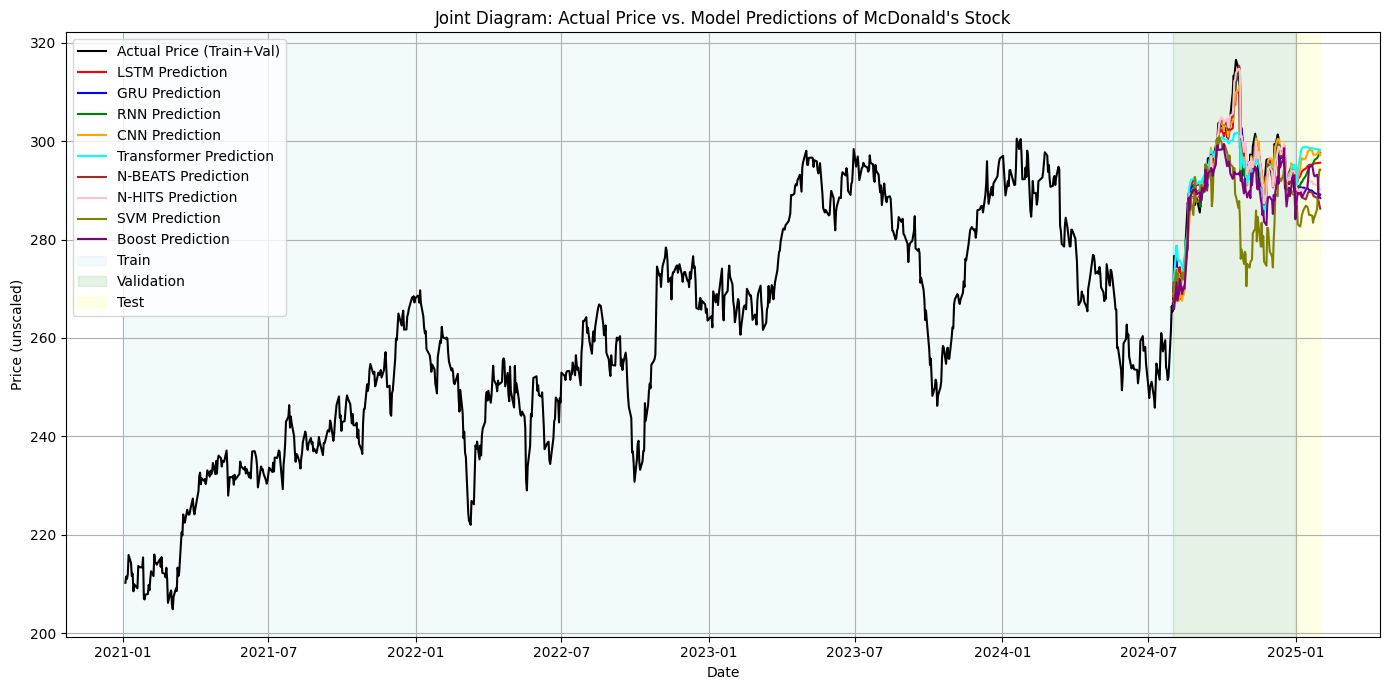

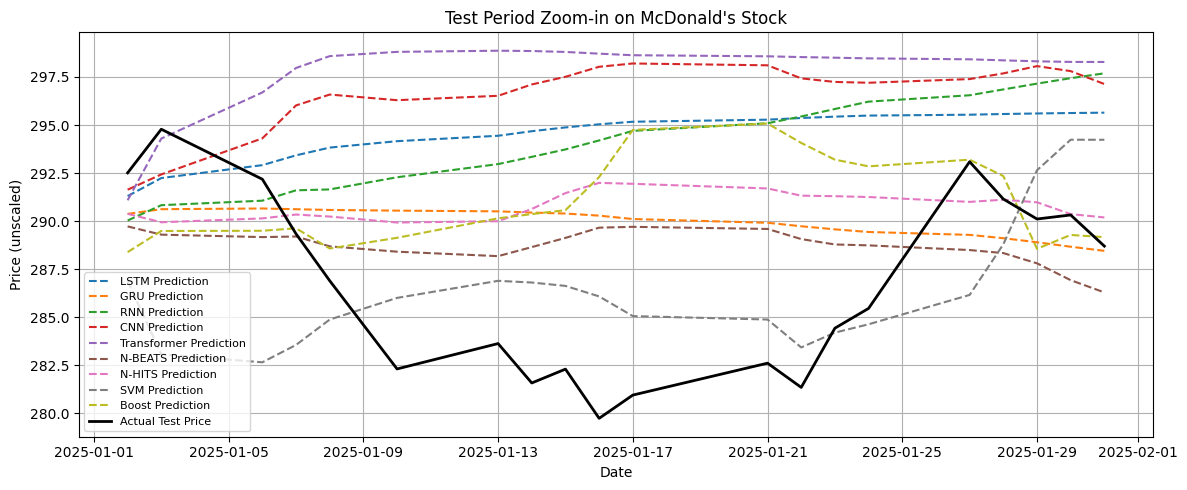

/tmp/ipykernel_632264/1252023054.py:713: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(pt_path, map_location=device))
/home/yuzhe/.local

===== ROLLING FORECASTS (MOE) =====
   ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
0    2025-01-02           288.389008          290.242615          291.973877   
1    2025-01-03           289.487549          289.181732          291.779816   
2    2025-01-04           289.497955          289.492096          291.487854   
3    2025-01-05           289.626770          288.591187          290.668213   
4    2025-01-06           288.573639          287.954132          289.095428   
5    2025-01-07           289.131653          288.241913          290.335571   
6    2025-01-08           290.146423          289.335022          290.602448   
7    2025-01-09           290.365387          290.856628          292.125702   
8    2025-01-10           290.570435          290.825867          291.598541   
9    2025-01-11           292.293671          290.800354          292.325470   
10   2025-01-12           294.745056          292.544434          294.695770   
11  

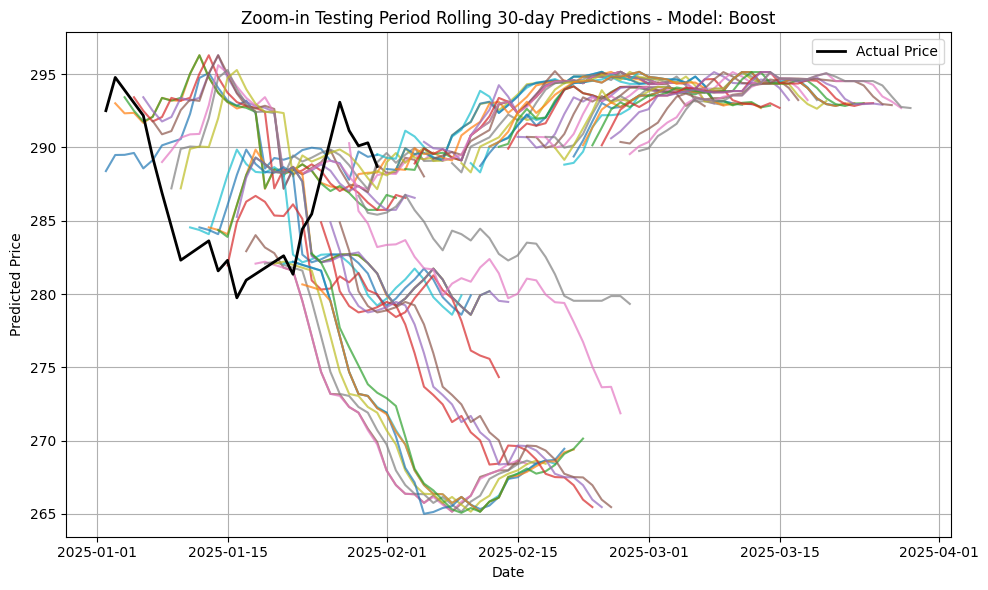

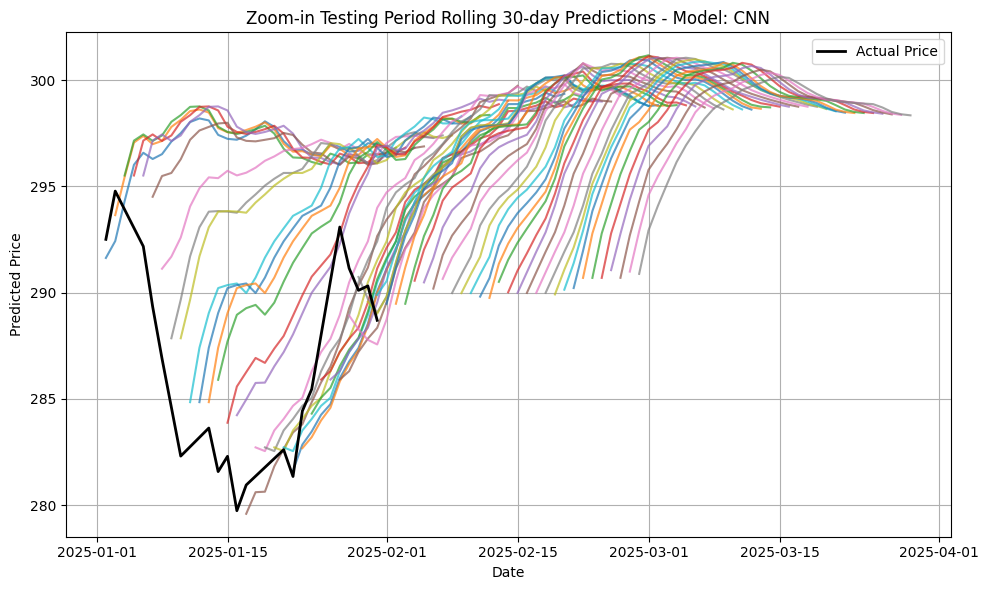

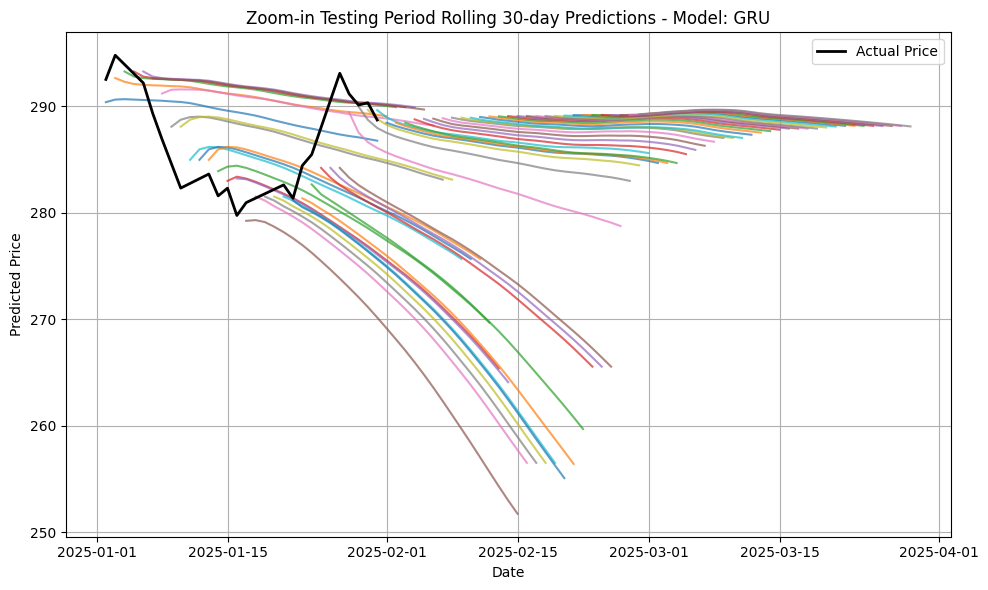

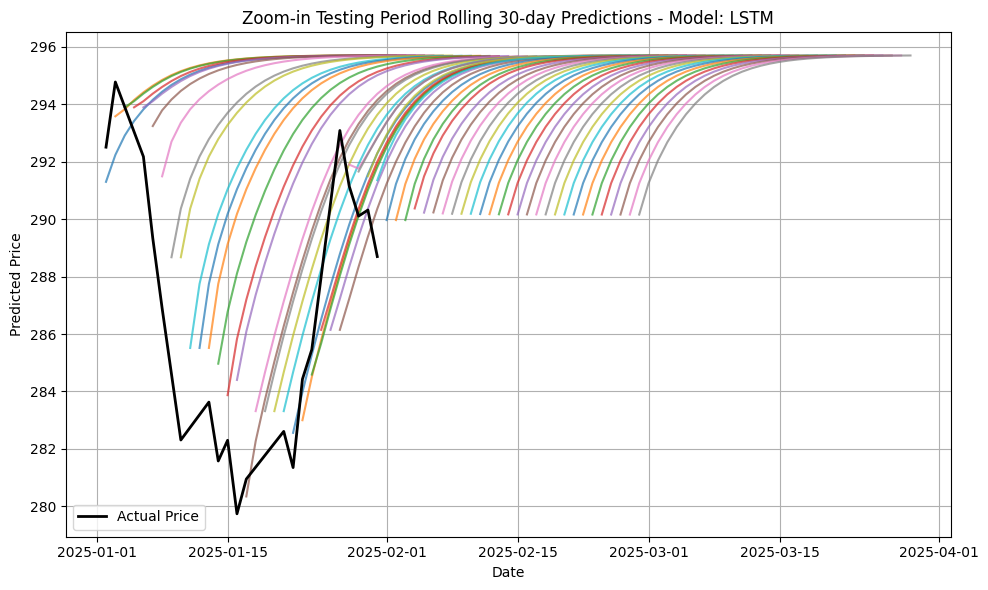

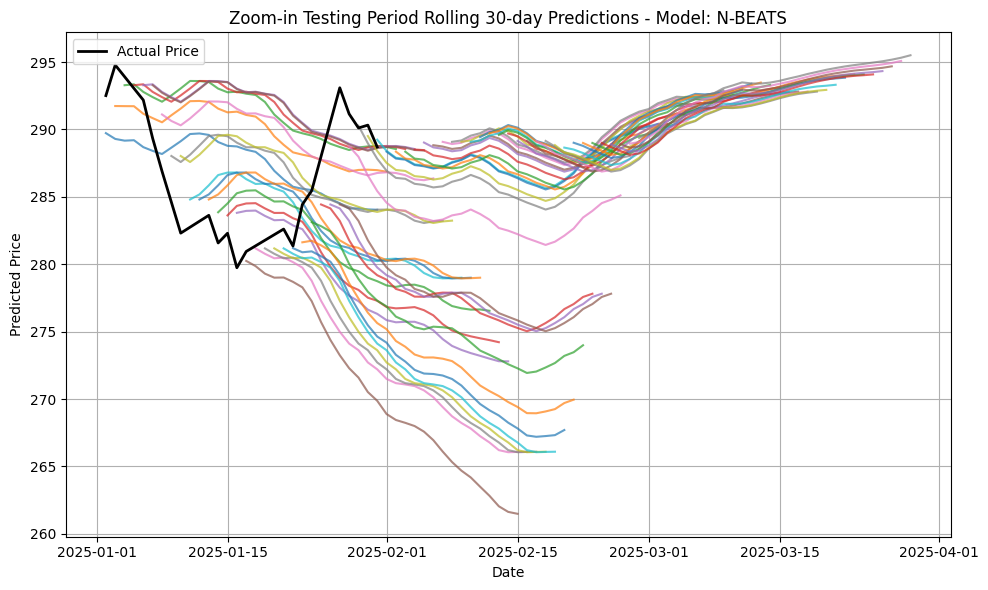

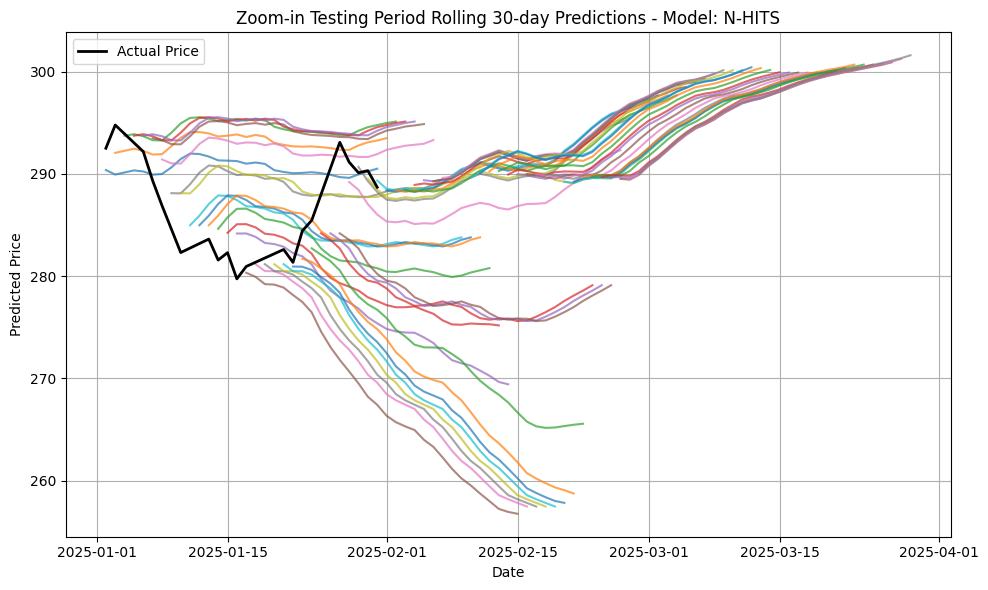

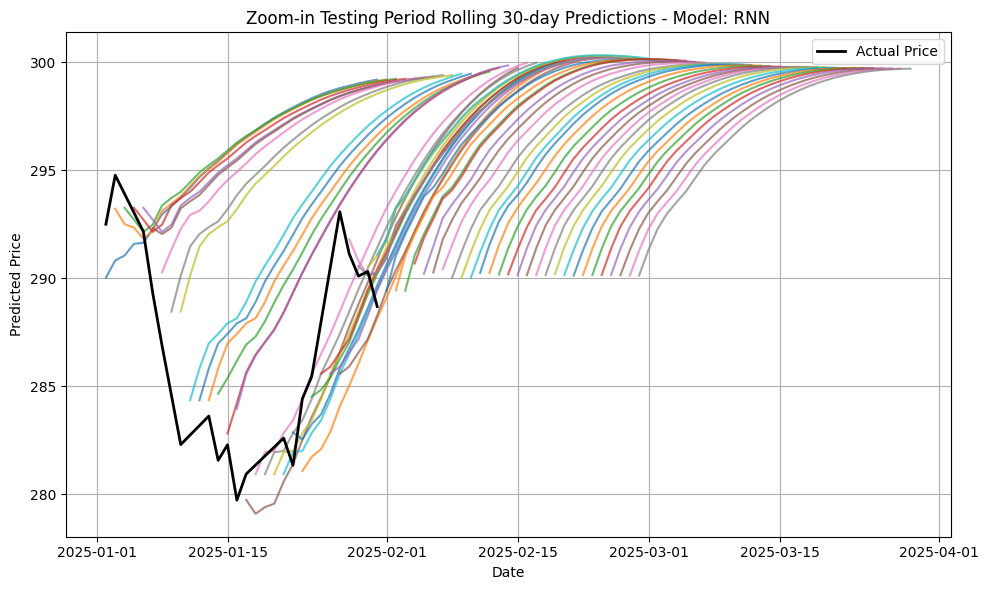

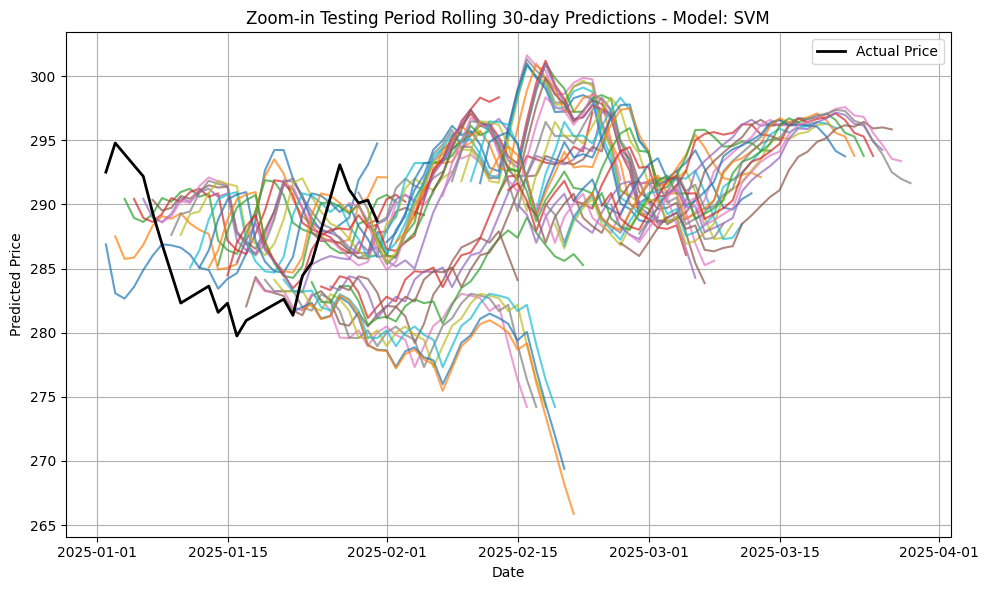

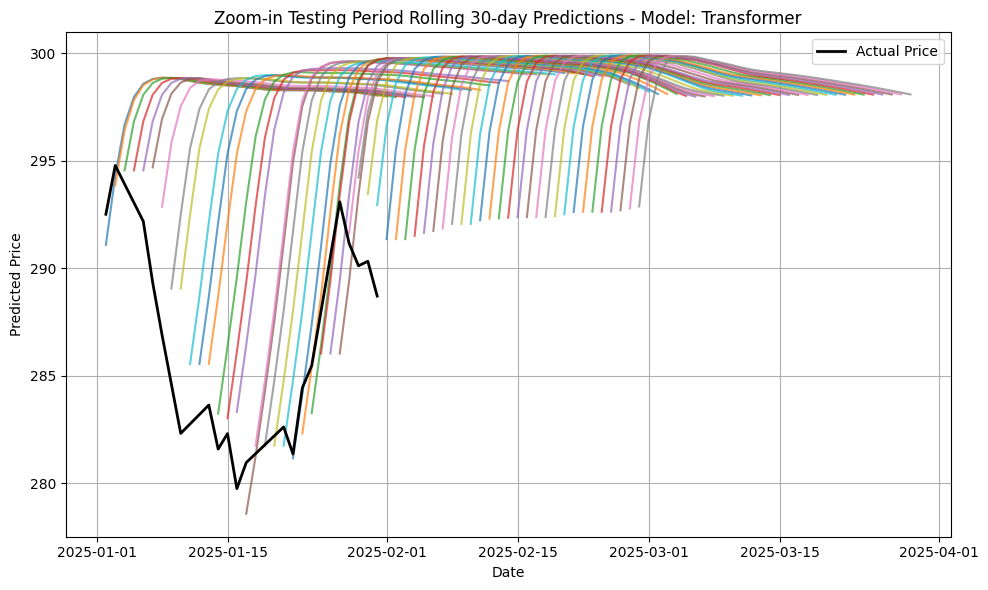

All done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ============================================
# 1. Set random seeds
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ============================================
# Global hyperparameters
# ============================================
WINDOW_SIZE = 35
NUM_EPOCHS  = 800
features = ["Price", "Open", "High", "Low"]

# Filenames (adjust as needed)
csv_file_train = "McDonald’s Stock Price History.csv"             # Partial / older data
csv_file_complete = "McDonald’s Stock Price History_Complete.csv"  # Full data (incl. future)
best_models_dir = "."  # Directory for saved models (change if needed)

# ============================================
# 2. Load & Clean CSV (Training CSV)
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# Train/Val/Test cutoff dates (adjust if needed)
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")  # We will do an extended approach later

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ============================================
# 3. Fit MinMaxScaler on TRAIN only
#    (We will re-use this scaler for all transforms)
# ============================================
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# Optionally, save the scaler if needed for later:
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create the training sequences
# ============================================
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Flatten for sklearn
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all shape: (n_samples, 4)

# ============================================
# 5. Validation Utilities
# ============================================
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    """
    For PyTorch models. On each validation day t, we feed the prior 'window' days
    (scaled actual) and measure MSE with the day t actual (scaled).
    """
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    """
    Non-iterative: each day in [val_start, val_end], we feed the prior 'window' days
    and store the single-day prediction. No re-insertion of predicted day into the window.
    """
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# Iterative validation approach for certain models
def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    """
    For each day in [val_start:val_end], we use the last 'window' actual (scaled) data
    to predict day t, then reveal day t's actual, then shift window and continue.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    # Initialize current window from the last 'window' rows before val_start
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            if d > val_end:
                break
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # Reveal actual
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 6. Define the base PyTorch model
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)  # [batch, window, 128]
            x = x.permute(1, 0, 2)    # [window, batch, 128]
            x = self.transformer_encoder(x)
            x = x[-1, :, :]          # last time step
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

# ============================================
# Early Stopping
# ============================================
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ============================================
# 7. Inverse transform helper
# ============================================
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ============================================
# 8. Training function for PyTorch models
# ============================================
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pt")
    
    # If the best model file exists, load and return the model immediately.
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    # Otherwise, train the model
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ============================================
# 8B. Training function for sklearn-based models
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pkl")
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ============================================
# 9. Walk-forward test
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    """
    The existing logic: for each day in test, we feed the last 'window' days, 
    then replace the actual day with predicted day in df_work, continuing.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 10. Evaluate & Plot
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    # Get the actual (unscaled) train+val data
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # Plot 1: Joint diagram
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    # Merge predictions from all models
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Test Period Zoom-in
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         linestyle="--", label=f"{model_name} Prediction")
        # Load actual test prices from the complete CSV for final overlay
        df_complete_test = pd.read_csv(csv_file_complete)
        df_complete_test["Date"] = pd.to_datetime(df_complete_test["Date"])
        df_complete_test.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete_test.sort_values("Date", inplace=True)
        df_test_actual = df_complete_test[df_complete_test["Date"] >= test_cutoff].copy()
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')

        plt.title("Test Period Zoom-in on McDonald's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# ============================================
# 11. MAIN (Original Approach) + Mixture of Experts Rolling
# ============================================
if __name__ == "__main__":
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}

    print("===== START TRAINING OR LOADING MODELS =====")
    for mt in all_model_types:
        print(f"\n=== Training/Loading {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)

        # Validation predictions
        if mt in ["SVM", "Transformer", "Boost"]:
            # Some prefer iterative validation
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )

        # Test predictions
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} => Completed test predictions")

    # Evaluate & plot the original approach
    evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff)

    # ============================================
    # Now the NEW PART: Mixture of Experts Rolling 30-day Forecast
    # ============================================

    # 1) Load the COMPLETE CSV
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"] = pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    for col in features:
        df_complete_all[col] = (
            df_complete_all[col].astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)

    # We'll re-use the same 'models_dict'
    # Construct or reload the final trained models into a dictionary:
    models_dict = {}
    for mt in all_model_types:
        if mt in ["SVM", "Boost", "GPR"]:
            pkl_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pkl")
            if not os.path.exists(pkl_path):
                print(f"Warning: {pkl_path} not found. Skipping.")
                continue
            loaded_model = joblib.load(pkl_path)
            models_dict[mt] = SklearnWrapper(loaded_model)
        else:
            pt_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pt")
            if not os.path.exists(pt_path):
                print(f"Warning: {pt_path} not found. Skipping.")
                continue
            new_model = BaseModel(model_type=mt, window_width=WINDOW_SIZE).to(device)
            new_model.load_state_dict(torch.load(pt_path, map_location=device))
            new_model.eval()
            models_dict[mt] = new_model

    # 2) Helper to get the last window of actual data
    def get_latest_window(actual_df, current_date, window=WINDOW_SIZE):
        mask = actual_df["Date"] < current_date
        df_subset = actual_df.loc[mask].copy()
        df_subset.sort_values("Date", inplace=True)
        if len(df_subset) < window:
            return None
        df_window = df_subset.iloc[-window:].copy()
        df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
        arr_window = scaler.transform(df_window[features])
        return arr_window

    # 3) Forecast 30 days from a single day vantage
    def forecast_30_days_from_date(model, df_actual, start_date, window=WINDOW_SIZE, horizon=30, device=device):
        arr_window = get_latest_window(df_actual, start_date, window=window)
        if arr_window is None:
            return pd.DataFrame()

        forecast_records = []
        rolling_buffer = np.copy(arr_window)
        current_date = pd.to_datetime(start_date)
        for i in range(horizon):
            X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_4_scaled = model(X_input).cpu().numpy()[0]

            pred_4_unscaled = scaler.inverse_transform(pred_4_scaled.reshape(1, -1))[0]
            forecast_day = current_date + pd.Timedelta(days=i)
            forecast_records.append({
                "ForecastDate": forecast_day,
                "Pred_Price_unscaled": pred_4_unscaled[0],
                "Pred_Open_unscaled":  pred_4_unscaled[1],
                "Pred_High_unscaled":  pred_4_unscaled[2],
                "Pred_Low_unscaled":   pred_4_unscaled[3],
            })
            # shift
            new_row_scaled = pred_4_scaled.reshape(1, -1)
            rolling_buffer = np.vstack((rolling_buffer[1:], new_row_scaled))

        return pd.DataFrame(forecast_records)

    # 4) Rolling day-by-day forecasts
    def rolling_moe_forecasts(
        models_dict,
        df_actual,
        test_start="2025-01-02",
        test_end="2025-02-28",
        window_size=WINDOW_SIZE,
        horizon=30,
        device=device
    ):
        df_actual["Date"] = pd.to_datetime(df_actual["Date"])
        test_start = pd.to_datetime(test_start)
        test_end   = pd.to_datetime(test_end)
        all_days = pd.date_range(start=test_start, end=test_end, freq="D")
        results_list = []

        for base_date in all_days:
            for model_name, model_obj in models_dict.items():
                df_fcst = forecast_30_days_from_date(
                    model=model_obj,
                    df_actual=df_actual,
                    start_date=base_date,
                    window=window_size,
                    horizon=horizon,
                    device=device
                )
                if df_fcst.empty:
                    continue
                df_fcst["BaseDate"] = base_date
                df_fcst["Model"] = model_name
                results_list.append(df_fcst)

        df_all_forecasts = pd.concat(results_list, ignore_index=True)
        df_all_forecasts.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
        df_all_forecasts.reset_index(drop=True, inplace=True)
        return df_all_forecasts

    # We'll do the rolling forecasts for the 2-month window
    final_rolling_fcst = rolling_moe_forecasts(
        models_dict=models_dict,
        df_actual=df_complete_all,
        test_start="2025-01-02",
        test_end="2025-02-28",
        window_size=WINDOW_SIZE,
        horizon=30,
        device=device
    )
    print("===== ROLLING FORECASTS (MOE) =====")
    print(final_rolling_fcst.head(50))
    print("Total rows in final_rolling_fcst:", len(final_rolling_fcst))

    # ============================================
    # 5) Additional Plots: Zoom in on Testing Period Price Predictions by each model
    #    (one diagram per model; total 9 if you have 9 models)
    # ============================================
    # We'll also load the actual price from the same complete CSV for reference
    df_complete_test = df_complete_all.copy()
    mask_test_period = (df_complete_test["Date"] >= "2025-01-02") & (df_complete_test["Date"] <= "2025-02-28")
    df_complete_test = df_complete_test.loc[mask_test_period].copy()

    # For convenience, let's just do a separate plot for each model
    unique_models = final_rolling_fcst["Model"].unique()

    for m in unique_models:
        df_model_fcst = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        # We might want to pick a single line for each "BaseDate" in that test window
        # or overlay them. Here we overlay each base date's 30-day horizon.
        plt.figure(figsize=(10,6))
        base_dates = df_model_fcst["BaseDate"].unique()
        for bd in base_dates:
            df_bd = df_model_fcst[df_model_fcst["BaseDate"] == bd]
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.7)
        plt.plot(df_complete_test["Date"], df_complete_test["Price"],
                 color="black", linewidth=2, label="Actual Price")
        plt.title(f"Zoom-in Testing Period Rolling 30-day Predictions - Model: {m}")
        plt.xlabel("Date")
        plt.ylabel("Predicted Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("All done.")
